In [1]:
from matplotlib import pyplot as plt
import numpy as np

from metrics.mot_ground_truth_assigner import MOTGroundTruthAssigner
from models.ocsort_utils.metric_utils import iou_batch


print(plt.rcParams["figure.figsize"])

[6.4, 4.8]


In [2]:
class PrecomputedMOTTracker():

    def __init__(self, seq_path=None):
        self.seq_dets = np.loadtxt(seq_path, delimiter=',')
        
        self.last_frame = int(self.seq_dets[:, 0].max())
    
    def __call__(self, frame):
        tracks = self.seq_dets[self.seq_dets[:, 0] == frame, :]
        return tracks

In [3]:
def center(tracks):
    cx = tracks[..., 0] + (tracks[..., 2] / 2.0)
    cy = tracks[..., 1] + (tracks[..., 3] / 2.0)

    return cx, cy

def compute_iou(tracks1, tracks2):
    xx1 = np.maximum(tracks1[..., 0], tracks2[..., 0])
    yy1 = np.maximum(tracks1[..., 1], tracks2[..., 1])
    xx2 = np.minimum(tracks1[..., 0] + tracks1[..., 2], tracks2[..., 0] + tracks2[..., 2])
    yy2 = np.minimum(tracks1[..., 1] + tracks1[..., 3], tracks2[..., 1] + tracks2[..., 3])

    w = np.maximum(0., xx2 - xx1)
    h = np.maximum(0., yy2 - yy1)

    intersection_area_matrix = w * h

    area_test = tracks1[..., 2] * tracks1[..., 3]
    area_gt = tracks2[..., 2] * tracks2[..., 3]

    union_area_matrix = (area_test + area_gt - intersection_area_matrix)

    iou = intersection_area_matrix / union_area_matrix

    return iou

In [4]:
def tracker_to_tracker_pca(tracker):
    tck_id_sort = np.argsort(tracker.seq_dets[:, 1], kind="stable")

    first_mask = ~(tracker.seq_dets[tck_id_sort[:-1], 1] == tracker.seq_dets[tck_id_sort[1:], 1]) # sorted
    first_mask = np.concatenate(([True], first_mask), axis=0)
    first_vals = tracker.seq_dets[tck_id_sort[first_mask], 2:4].copy()

    centers = np.array(center(tracker.seq_dets[:, 2:6])).T # unsorted
    desplazamiento = centers[tck_id_sort[1:], :] - centers[tck_id_sort[:-1], :] # sorted
    modulos = np.linalg.norm(desplazamiento, axis=1).reshape(-1, 1) # sorted

    pos_neg = np.ones(desplazamiento[:, 1].shape).reshape(-1, 1)
    pos_neg[desplazamiento[:, 1] < 0] = -1 # sorted
    angulos_kalman = np.pi / 2 - np.arccos(desplazamiento[:, 0].reshape(-1, 1) / modulos) * pos_neg # sorted

    angulos_pca = tracker.seq_dets[tck_id_sort, 9][:-1].reshape(-1, 1) # sorted
    angle_dist = np.min((np.abs(angulos_kalman - angulos_pca), 2 * np.pi - np.abs(angulos_kalman - angulos_pca)), axis=0) #sorted
    angulos_pca[(2 * angle_dist) >= np.pi] = angulos_pca[(2 * angle_dist) >= np.pi] - np.pi

    origins = tracker.seq_dets[tck_id_sort, 2:4][:-1, :].reshape(-1, 2)
    tracker.seq_dets[tck_id_sort[1:], 2:4] = origins + modulos * np.hstack([np.sin(angulos_pca), np.cos(angulos_pca)]).reshape(-1, 2)
    tracker.seq_dets[tck_id_sort[first_mask], 2:4] = first_vals

def process_assigments(assigments, tracks, gt_tracks, prev_tracks):
    
    gt_tck_iou = []
    gt_tck_angle_err = []

    for gt, tck in assigments:

        gt_tck_iou.extend(compute_iou(gt_tracks[gt_tracks[:, 1] == gt, 2:6], tracks[tracks[:, 1] == tck, 2:6]))

        if tck in set(prev_tracks[:, 1]):
            origin_track = np.array(center(prev_tracks[prev_tracks[:, 1] == tck, 2:6]))
            gt_track = np.array(center(gt_tracks[gt_tracks[:, 1] == gt, 2:6]))
            pred_track = np.array(center(tracks[tracks[:, 1] == tck, 2:6]))
            
            o_gt = gt_track - origin_track
            m_o_gt = np.linalg.norm(o_gt) + np.finfo(o_gt.dtype).eps
            
            o_tck = pred_track - origin_track
            m_o_tck = np.linalg.norm(o_tck) + np.finfo(o_tck.dtype).eps

            a_err_o_tck = np.arccos(np.dot(o_tck.T, o_gt)[0, 0] / (m_o_tck * m_o_gt)) * 180 / np.pi
            gt_tck_angle_err.append(a_err_o_tck)
    
    return gt_tck_iou, gt_tck_angle_err

In [5]:

gt_tracker = PrecomputedMOTTracker('./DATA/output_4_gt.txt')
#tracker = PrecomputedMOTTracker('./OUTPUT/ocsort_tracking_output_4_kalman.txt')
#tracker = PrecomputedMOTTracker('./OUTPUT/output_4_dets_pca.txt')
tracker = PrecomputedMOTTracker('./OUTPUT/output_4_kalman_pca.txt')

pca_tracker = PrecomputedMOTTracker('./OUTPUT/output_4_kalman_pca.txt')
tracker_to_tracker_pca(pca_tracker)

In [6]:
iou_batch_dist = lambda bb_test, bb_gt : 1 - iou_batch(bb_test, bb_gt)
tracks_assigner = MOTGroundTruthAssigner(iou_batch_dist, 0.5)
pca_tracks_assigner = MOTGroundTruthAssigner(iou_batch_dist, 0.5)

gt_tck_angle_err = []
gt_tck_iou = []

gt_pca_angle_err = []
gt_pca_iou = []

for frame in range(1, gt_tracker.last_frame + 1):

    gt_tracks = gt_tracker(frame)
    pca_tracks = pca_tracker(frame)
    tracks = tracker(frame)

    prev_pca_tracks = pca_tracker(frame - 1)
    prev_tracks = tracker(frame - 1)

    assigments = tracks_assigner(gt_tracks, tracks) # IDs gt, IDs tck
    pca_assigments = pca_tracks_assigner(gt_tracks, pca_tracks) # IDs gt, IDs tck

    iou, ang_err = process_assigments(assigments, tracks, gt_tracks, prev_tracks)
    pca_iou, pca_ang_err = process_assigments(pca_assigments, pca_tracks, gt_tracks, prev_pca_tracks)

    gt_tck_angle_err.extend(ang_err)
    gt_tck_iou.extend(iou)
    gt_pca_angle_err.extend(pca_ang_err)
    gt_pca_iou.extend(pca_iou)


Text(0.5, 1.0, 'angle error (pca_track - ground truth)')

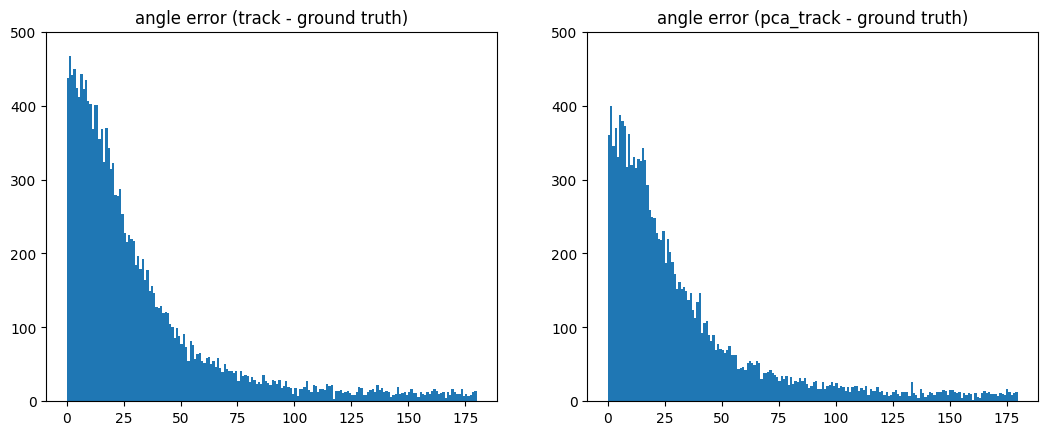

In [7]:
plt.figure(figsize=(6.4 * 2, 4.8))
plt.subplot(1, 2, 1)
plt.ylim(0, 500)
plt.hist(gt_tck_angle_err, bins=180)
plt.title('angle error (track - ground truth)')

#gt_tck_angle_err = np.abs(np.asarray(gt_tck_angle_diff))

plt.subplot(1, 2, 2)
plt.ylim(0, 500)
plt.hist(gt_pca_angle_err, bins=180)
plt.title('angle error (pca_track - ground truth)')

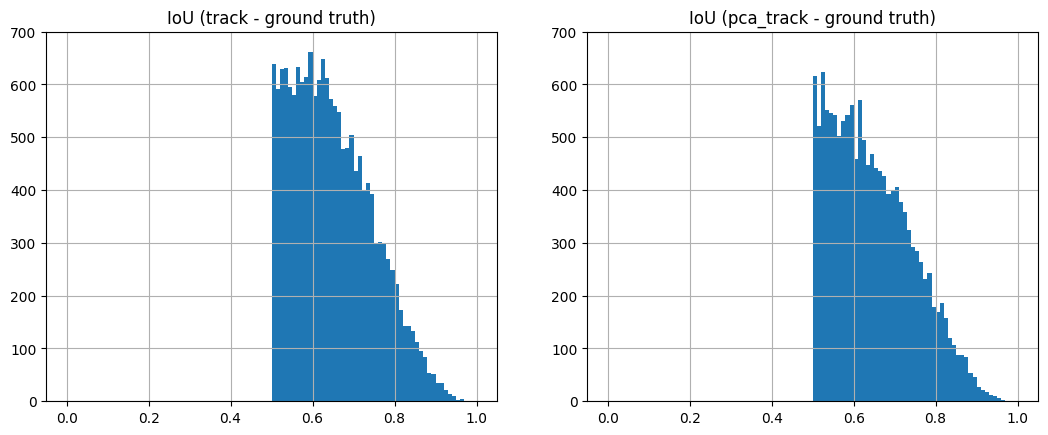

In [10]:
plt.figure(figsize=(6.4 * 2, 4.8))
plt.subplot(1, 2, 1)
plt.hist(gt_tck_iou, bins=100, range=[0, 1])
plt.ylim(0, 700)
plt.title('IoU (track - ground truth)')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(gt_pca_iou, bins=100, range=[0, 1])
plt.ylim(0, 700)
plt.title('IoU (pca_track - ground truth)')
plt.grid(True)

Text(0.5, 1.0, 'High IoU (pca_track - ground truth)')

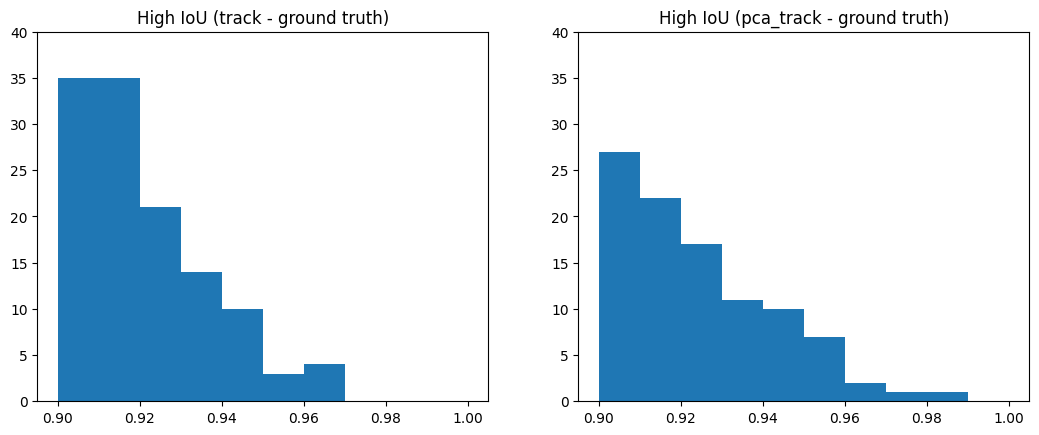

In [9]:
plt.figure(figsize=(6.4 * 2, 4.8))
plt.subplot(1, 2, 1)
plt.hist(gt_tck_iou, bins=10, range=[0.9, 1])
plt.ylim(0, 40)
plt.title('High IoU (track - ground truth)')

plt.subplot(1, 2, 2)
plt.hist(gt_pca_iou, bins=10, range=[0.9, 1])
plt.ylim(0, 40)
plt.title('High IoU (pca_track - ground truth)')